# Figures for Chapter 4

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 500
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

## Vehicle params

In [3]:
def get_basic_weight(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    return None if ((data=='-') or (data=='nan')) else int(data)

def get_basic_brake(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    if '通风盘式' in data:
        return 'ventiled'
    elif '盘式' in data:
        return 'disc'
    elif '鼓式' in data:
        return 'drum'
    else:
        return None

car_map = {
    'SUV': 'SUV', 
    'MPV': 'MPV',
    '微型车': 'microcar',
    '小型车': 'small car',
    '紧凑型车': 'compact car',
    '中型车': 'mid-size car',
    '中大型车': 'large car',
    '大型车': 'luxury car',
    '跑车': 'sports car',
    '不限': None
}

def get_class(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    for k,v in car_map.items():
        if k in data:
            return v

fuel_type_map = {
    '增程': 'REEV',
    '新能源': 'NEV',
    '油电混合': 'HEV',
    '燃油车': 'ICEV', 
    '纯电动': 'BEV'
}

def get_fuel_type(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    if '汽油' in data:
        return 'ICEV'
    elif '纯电动' in data:
        return 'BEV'
    elif '混' in data:
        return 'HEV'
    else:
        return 'others'

In [6]:
raw = pd.read_excel('car registration/data/car_sale_2015_16.xlsx')
raw.dropna(inplace=True)
raw.reset_index(drop=True, inplace=True)

sales = raw.copy()
sales['weight'] = sales['weight'].map(get_basic_weight)
sales['frontB'] = sales['frontB'].map(get_basic_brake)
sales['rearB'] = sales['rearB'].map(get_basic_brake)
sales['fuel'] = sales['fuel'].map(get_fuel_type)
sales['class'] = sales['class'].map(get_class)

ps_level_list = ['small car', 'compact car', 'mid-size car', 'large car']
ps_car = sales[(sales['class'].isin(ps_level_list)) & (sales['fuel'] == 'ICEV')].copy()

### Weight

In [7]:
num_weight = []  # weighted numbers of weight
ps_car_weight = ps_car[ps_car['weight'].notna()].copy()

for index, row in ps_car_weight.iterrows():
    weights = [row['weight']] * int(row['sales'] / 100)
    num_weight += weights

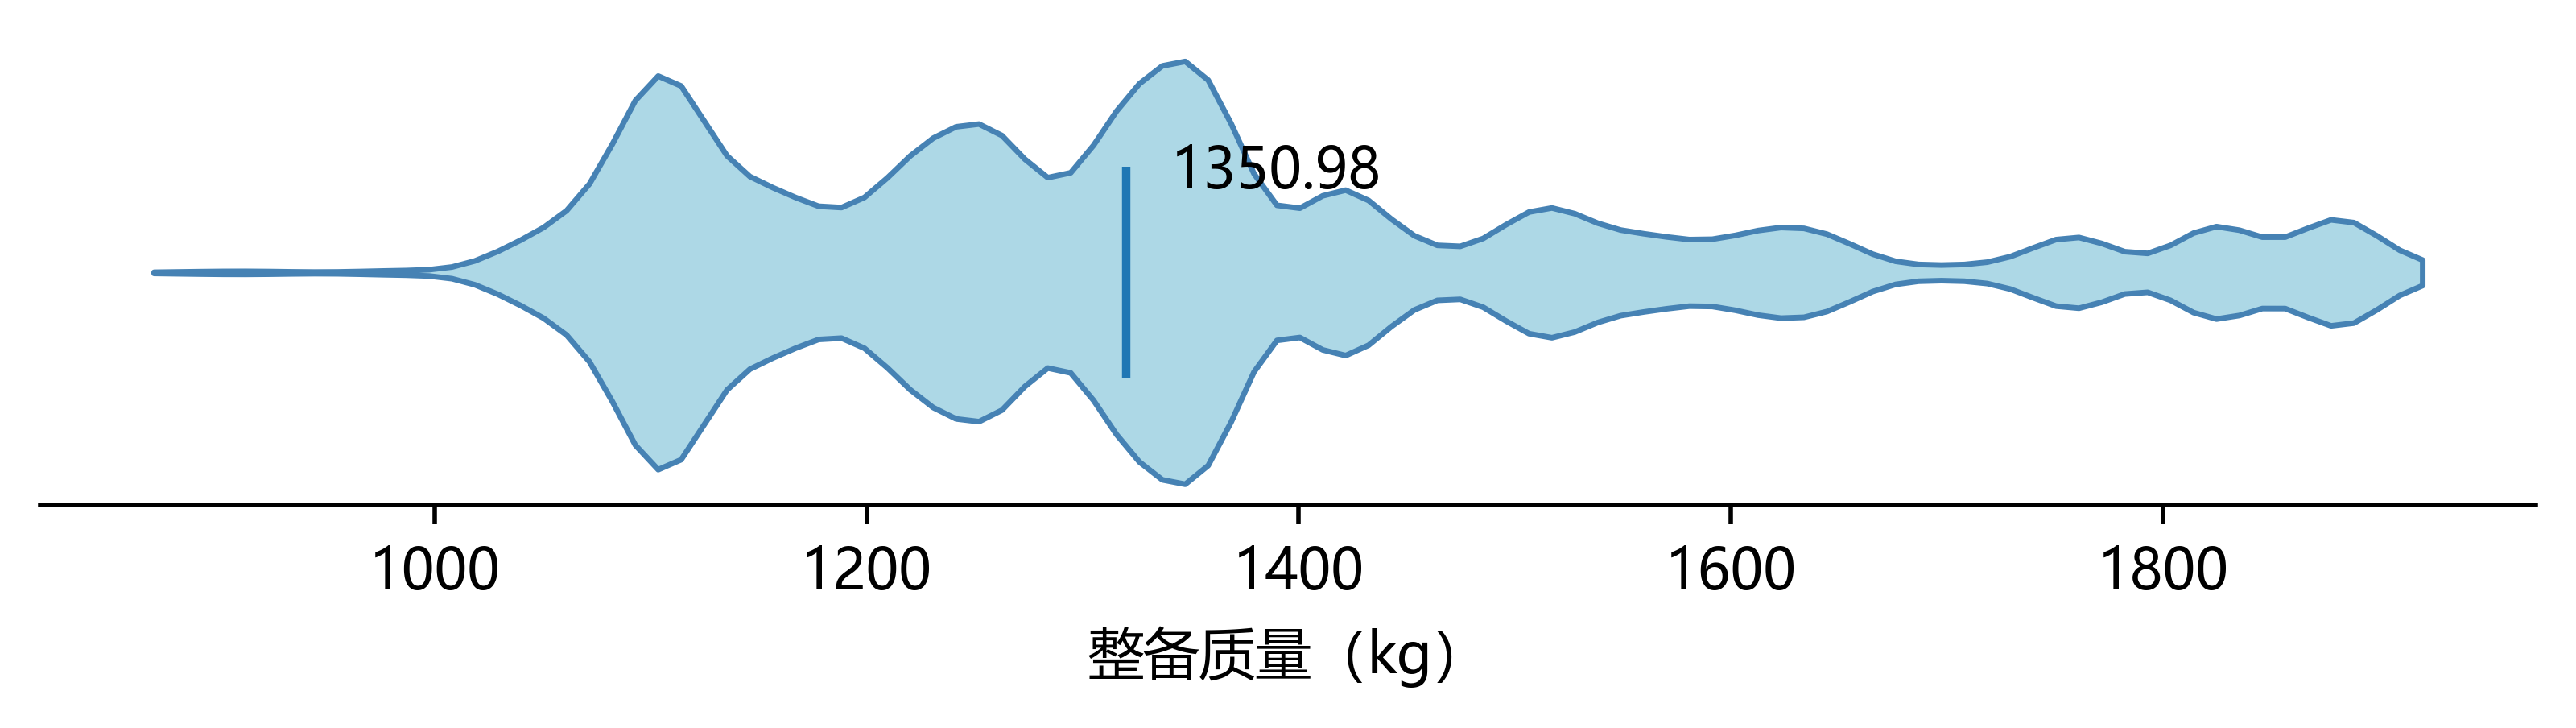

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,1.5))

parts = ax.violinplot(
    [num_weight],
    vert=False,
    showmeans=False,
    showmedians=True,
    showextrema=False,
)

for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('steelblue')
    pc.set_alpha(1)

mean = sum(num_weight) / len(num_weight)
ax.text(mean-10, 1.1, "%.2f" % mean, ha='left')

ax.set_yticks([])
ax.set_xlabel('整备质量（kg）')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### brake

In [11]:
ps_car['frontB'] = ps_car['frontB'].map({'ventiled': 'disc', 'disc': 'disc', 'drum':'drum'})
front_brake_num = ps_car[['sales', 'frontB']].groupby(by=['frontB']).sum()
front_brake_num.loc['drum', 'sales'] = 0
front_brake_num['prop'] = front_brake_num['sales'] / front_brake_num['sales'].sum()

ps_car['rearB'] = ps_car['rearB'].map({'ventiled': 'disc', 'disc': 'disc', 'drum':'drum'})
rear_brake_num = ps_car[['sales', 'rearB']].groupby(by=['rearB']).sum()
rear_brake_num['prop'] = rear_brake_num['sales'] / rear_brake_num['sales'].sum()

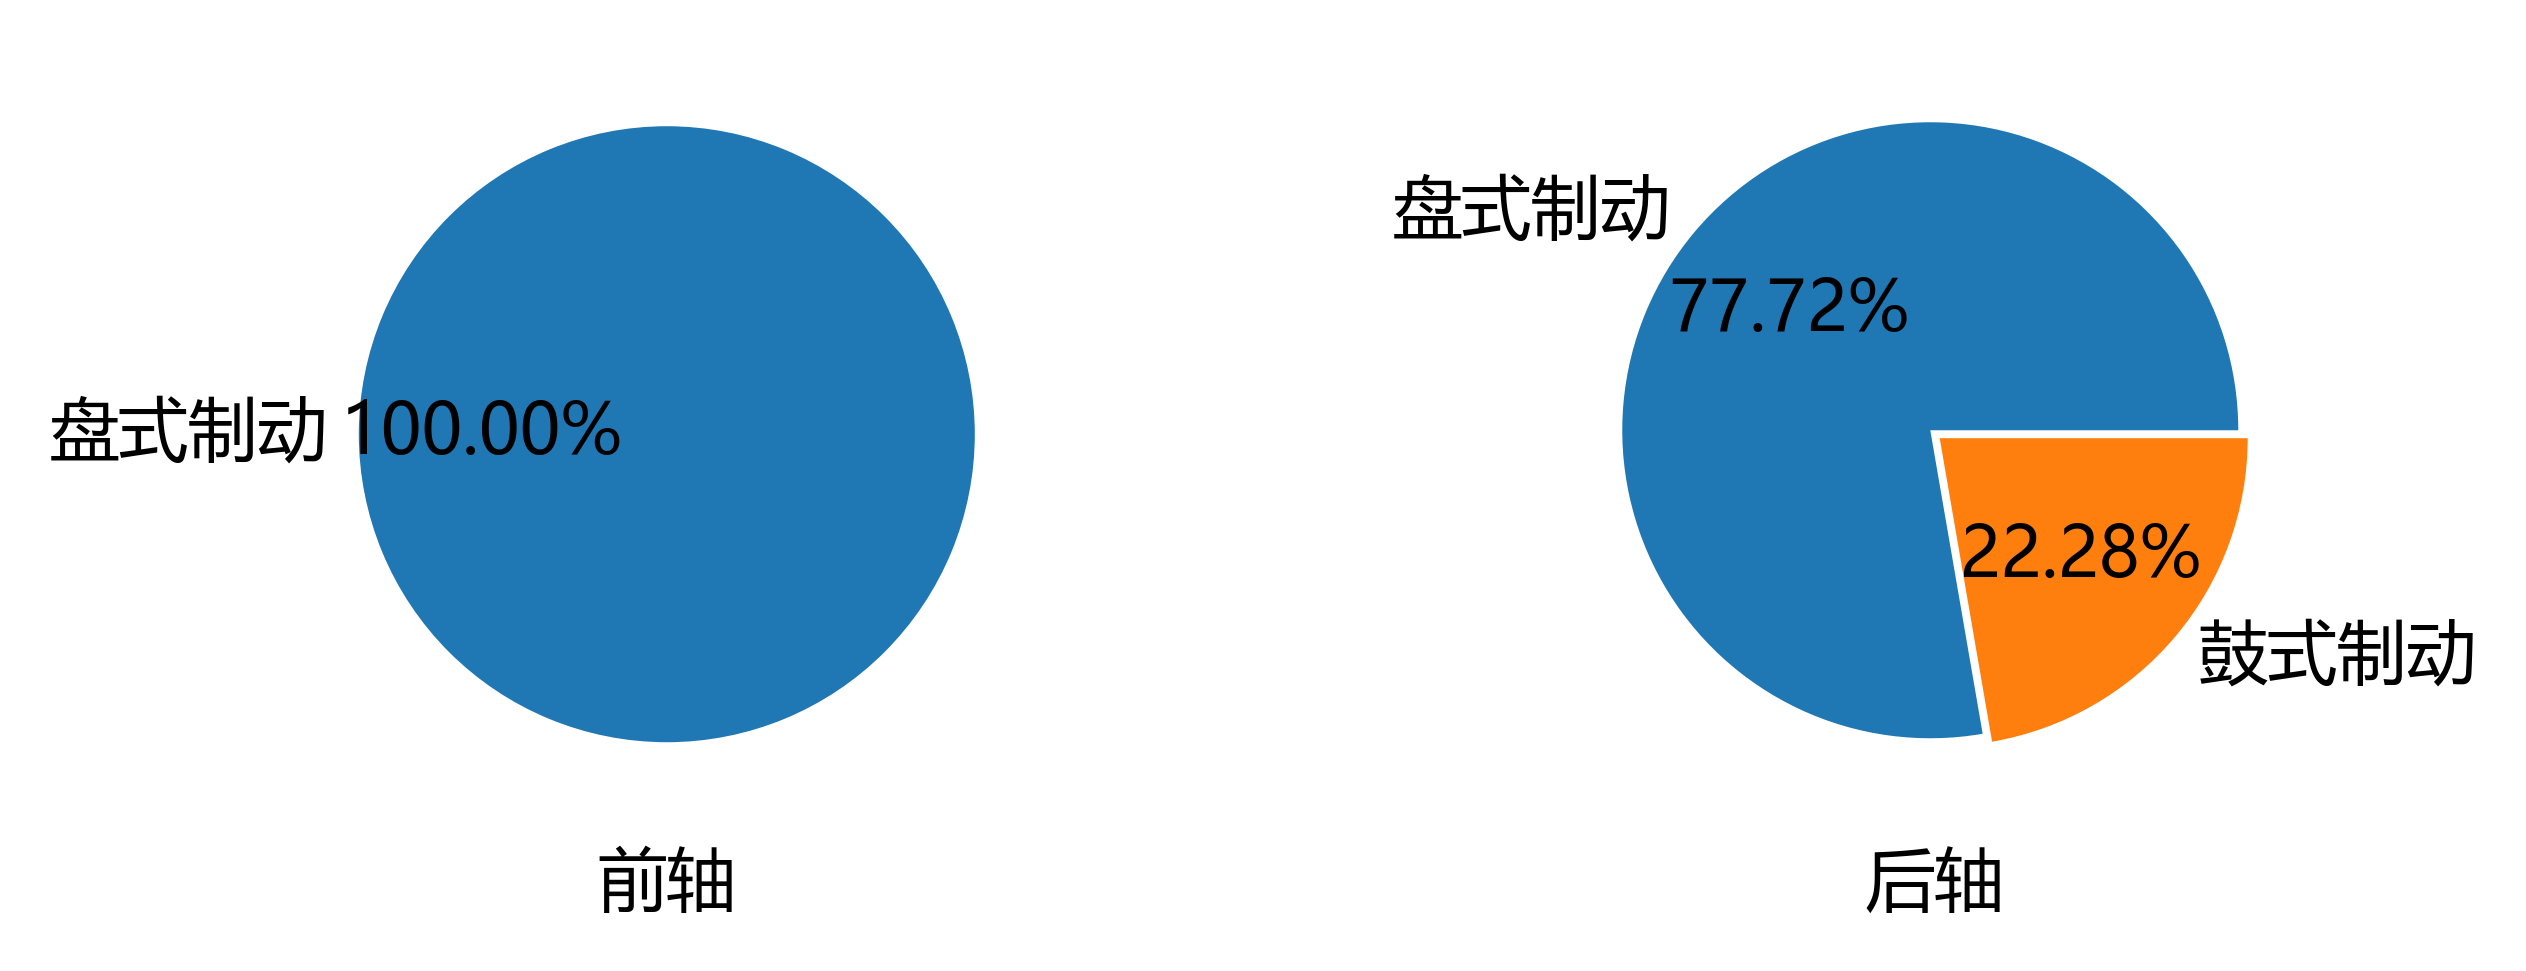

In [14]:
fig, ax = plt.subplots(1,2, figsize=(6,2))
# fig.subplots_adjust(wspace=2)

front = front_brake_num['prop']
rear = rear_brake_num['prop']

ax[0].pie(
    [1],
    labels = ['盘式制动'],
    autopct='%.2f%%',
    colors = plt.get_cmap('tab10')([0])
)
ax[0].set_xlabel('前轴')

ax[1].pie(
    rear.values,
    explode = [0.02, 0.02],
    # explode = [0.01, 0.03, 0.01, 0.01],
    labels = ['盘式制动', '鼓式制动'],
    autopct='%.2f%%',
    colors = plt.get_cmap('tab10')(range(rear.shape[0]))
)
ax[1].set_xlabel('后轴')

plt.show()

## Brake Type

In [16]:
import os
read_path = 'e-goods sale/jd/comments'
files = os.listdir(read_path)

df = pd.DataFrame()
for file in files:
    df_ = pd.read_excel(read_path+'/'+file)
    df = pd.concat([df, df_])
df.reset_index(inplace=True, drop=True)
df.replace('semimetalic', 'semi-metallic', inplace=True)

agg = df[['comments', 'brake type', 'material']].groupby(by=['brake type', 'material']).sum()
agg['prop'] = None
comments_sum = df[['comments', 'brake type']].groupby(by=['brake type']).sum()
agg.loc['front', 'prop'] = list(agg.loc['front','comments'] / comments_sum.loc['front']['comments'])
agg.loc['rear', 'prop'] = list(agg.loc['rear','comments'] / comments_sum.loc['rear']['comments'])

df_ = df.replace('ceramic', 'NAO')
agg_ = df_[['comments', 'brake type', 'material']].groupby(by=['brake type', 'material']).sum()
agg_['prop'] = None
agg_.loc['front', 'prop'] = list(agg_.loc['front','comments'] / comments_sum.loc['front']['comments'])
agg_.loc['rear', 'prop'] = list(agg_.loc['rear','comments'] / comments_sum.loc['rear']['comments'])

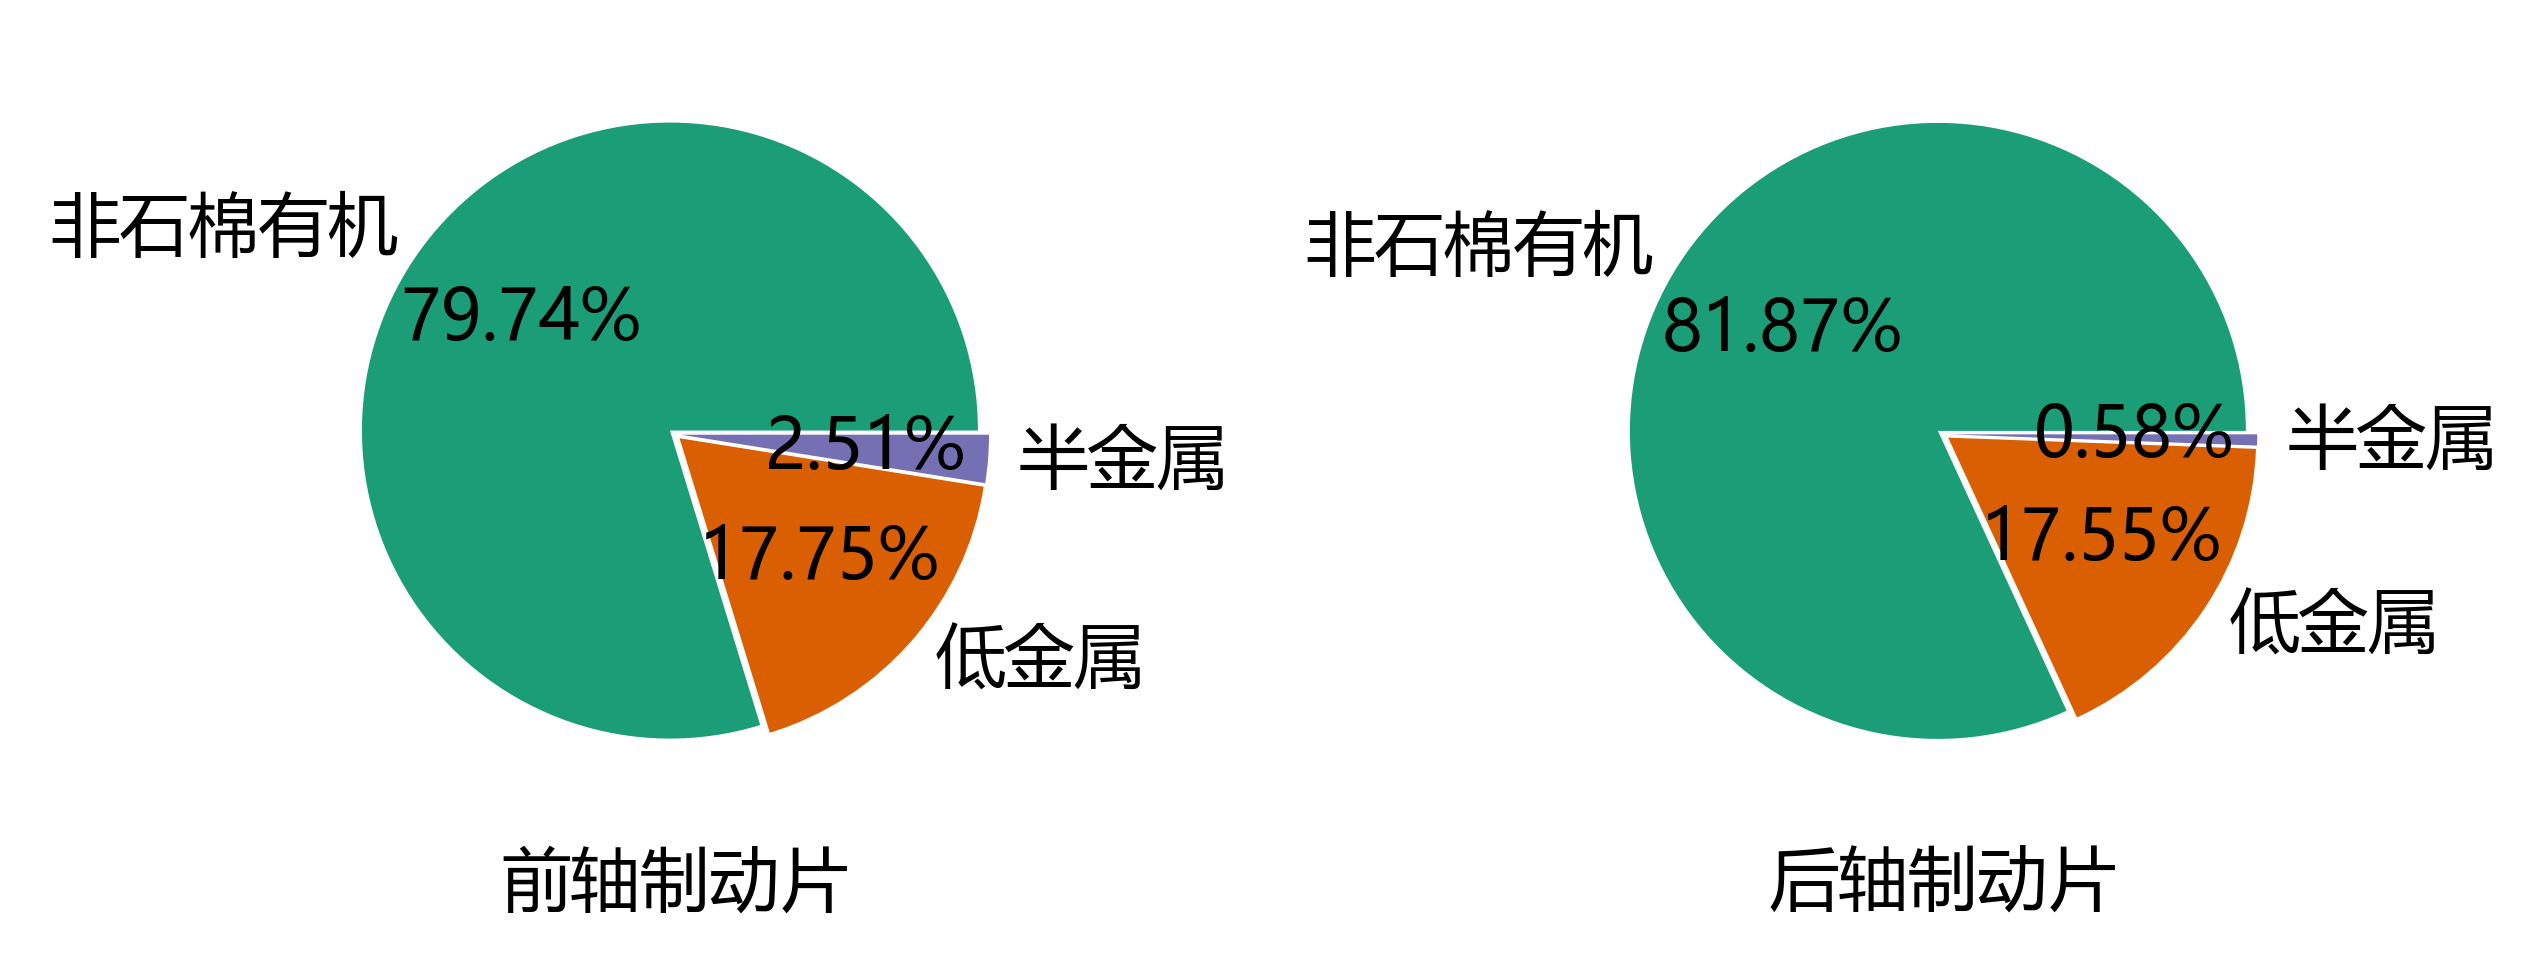

In [19]:
fig, ax = plt.subplots(1,2, figsize=(6,2))

front = agg_.loc['front', 'prop']
rear = agg_.loc['rear', 'prop']

ax[0].pie(
    front.values,
    explode = [0.02, 0.02, 0.02],
    labels = ['非石棉有机', '低金属', '半金属'],
    autopct='%.2f%%',
    colors = plt.get_cmap('Dark2')(range(front.shape[0]))
)
ax[0].set_xlabel('前轴制动片')

ax[1].pie(
    rear.values,
    explode = [0.02, 0.02, 0.02],
    # explode = [0.01, 0.03, 0.01, 0.01],
    labels = ['非石棉有机', '低金属', '半金属'],
    autopct='%.2f%%',
    colors = plt.get_cmap('Dark2')(range(rear.shape[0]))
)
ax[1].set_xlabel('后轴制动片')

plt.show()